## Homework
Your homework is to create a new notebook modeled after this one, where:

- You've put all of your cleaning and prepration steps into a functions you load and use in a module.
- You create and train a simple appropriate model for your task.
- You assess the performance using the appropriate metric for your task.
- Try a few different hyper-parameters to see if you can get better performance.
- Compare the performance with your previous best non Deep Neural Network model. This probably will mean you copy and paste your training from your other notebook into this notebook.

### Load Data

In [36]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.special import boxcox1p
from scipy.stats import skew
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import OneHotEncoder

In [37]:
# Load the data
df = pd.read_csv('../../../playground-series-s4e3/train.csv', index_col='id')
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [38]:
# define the lists of column names

column_names = df.columns.tolist()
#print("Column names:\n\n", column_names, end='\n\n')
features_all = column_names[:27]
#print('All Features:\n\n', features_all, end='\n\n')
features_cat = [features_all[11],features_all[12],features_all[20]]
#print('Categorical features:\n\n', features_cat, end='\n\n')
features_num = [i for i in features_all if i not in features_cat]
#print('Numerical features:\n\n', features_num, end='\n\n')
defect_types = column_names[27:34]
#print('Defect types:\n\n', defect_types)

### Create label encoded defect column

In [39]:
# Create single categorical Defect column to encode target more conveniently 
df['Defect'] = df[defect_types].idxmax(axis=1)
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,Defect
id,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.0104,0.1417,0,0,0,1,0,0,0,Stains
1,808,816,728350,728372,433,20,54,44478,70,111,...,-0.2997,0.9491,0,0,0,0,0,0,1,Other_Faults
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0944,1.0000,0,0,1,0,0,0,0,K_Scatch
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,-0.0402,0.4025,0,0,1,0,0,0,0,K_Scatch
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,-0.2455,0.9998,0,0,0,0,0,0,1,Other_Faults


### Drop rows labeled with no defect or multiple defects

In [40]:
# Clean up dulpicate and zero output rows

print(df.shape)

# define rows w/ no defect and rows w/ 2 defects
zero_rows = df[df[defect_types].sum(axis=1)==0].index
multi_rows = df[df[defect_types].sum(axis=1)>1].index

# drop zero rows from df
df.drop(zero_rows, axis=0, inplace=True)
#drop multi defect rows from df
df.drop(multi_rows, axis=0, inplace=True)

# Reset the index
df.reset_index(inplace=True, drop=True)

print(df.shape)

(19219, 35)
(18380, 35)


### Apply scaling and transformation

In [41]:

skewed_features = df[features_num].apply(lambda x: skew(x)).sort_values(ascending=False)

skewed_features_df = pd.DataFrame(skewed_features, columns={'Skew'})

lam = 0.15
cols = skewed_features_df.index

# Perform boxcox1p transformation
scaled_features = pd.DataFrame({c: boxcox1p(df[c] + 1e-6, lam) for c in cols})

# Define second sacaler
mmscaler = MinMaxScaler()

# Perform fit (to find mean, std, min, max) and transform data (to fit in [0,1]) in one move 
scaled_features = pd.DataFrame(mmscaler.fit_transform(scaled_features), columns=scaled_features.columns)

# Recobine scaled feature data frame with the rest
scaled_df = pd.concat([scaled_features, df[features_cat], df[defect_types], df['Defect']], axis=1)

scaled_df.head(10)

,Pixels_Areas,Sum_of_Luminosity,X_Perimeter,Outside_X_Index,Y_Perimeter,Y_Minimum,Y_Maximum,Steel_Plate_Thickness,Maximum_of_Luminosity,Log_X_Index,...,TypeOfSteel_A400,Outside_Global_Index,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,Defect
0,0.040967,0.097769,0.080080,0.008301,0.080906,0.515431,0.515370,0.095480,0.509560,0.320167,...,1,0.0,0,0,0,1,0,0,0,Stains
1,0.246677,0.292926,0.151512,0.005475,0.403896,0.482949,0.482888,0.308503,0.329169,0.261679,...,0,1.0,0,0,0,0,0,0,1,Other_Faults
2,0.584707,0.651606,0.567057,0.192235,0.811725,0.656387,0.656348,0.000000,0.515195,0.782047,...,1,0.0,0,0,1,0,0,0,0,K_Scatch
3,0.191879,0.116054,0.132839,0.005475,0.304619,0.729136,0.729103,0.000000,0.475014,0.261679,...,1,1.0,0,0,1,0,0,0,0,K_Scatch
4,0.261684,0.299557,0.274505,0.033207,0.440835,0.459768,0.459710,1.000000,0.329169,0.530193,...,1,1.0,0,0,0,0,0,0,1,Other_Faults
5,0.242136,0.298323,0.159736,0.007171,0.288264,0.513671,0.513622,0.246315,0.376061,0.343159,...,0,1.0,0,0,0,0,0,0,1,Other_Faults
6,0.189808,0.240148,0.155704,0.017884,0.257206,0.485048,0.880496,0.000000,0.433020,0.437431,...,1,1.0,0,0,0,0,0,1,0,Bumps
7,0.269275,0.307601,0.209750,0.023876,0.413032,0.361283,0.361213,1.000000,0.322268,0.517180,...,1,1.0,1,0,0,0,0,0,0,Pastry
8,0.104274,0.162004,0.060580,0.004154,0.210765,0.574694,0.574640,0.176178,0.469130,0.222755,...,0,1.0,0,0,0,0,0,1,0,Bumps
9,0.215314,0.267650,0.207196,0.020695,0.362491,0.459768,0.459710,0.700772,0.433020,0.459288,...,1,1.0,0,0,0,0,0,1,0,Bumps


### Feature engineering

In [70]:

# If we do some feature engineering, we can reduce the number of columns in our data
# X and Y Max and Min can ech be combined into X_Range and Y_Range making 4 columns into 2
scaled_df['X_Range'] = scaled_df['X_Maximum'] - scaled_df['X_Minimum']
scaled_df['Y_Range'] = scaled_df['Y_Maximum'] - scaled_df['Y_Minimum']

# Because the perimeter lengths along the X and Y axis are correlated we combine them to make the area of a defect
scaled_df['Defect_Area'] = scaled_df['X_Perimeter'] * scaled_df['Y_Perimeter']

# We can determine the range of luminosity within any one defect using the max and min of luminosity
scaled_df['Luminosity_Range'] = scaled_df['Maximum_of_Luminosity'] - scaled_df['Minimum_of_Luminosity']

# LogOfAreas, Log_X_Index, and Log_Y_Index are all positively correlated, so we can combine them into a single feature
scaled_df['LogA'] = scaled_df['LogOfAreas'] / (scaled_df['Log_X_Index'] * scaled_df['Log_Y_Index'] + 0.000001) # add small amt to avoid dividing by 0

# Drop unnecessary columns
redundant_cols = ['X_Maximum','X_Minimum','Y_Maximum','Y_Minimum','X_Perimeter','Y_Perimeter',
                  'Maximum_of_Luminosity','Minimum_of_Luminosity','LogOfAreas','Log_X_Index','Log_Y_Index']
engineered_df = scaled_df.drop(redundant_cols, axis=1)
display(engineered_df.head())


,Pixels_Areas,Sum_of_Luminosity,Outside_X_Index,Steel_Plate_Thickness,Length_of_Conveyer,Luminosity_Index,Edges_Index,SigmoidOfAreas,Empty_Index,Square_Index,...,Stains,Dirtiness,Bumps,Other_Faults,Defect,X_Range,Y_Range,Defect_Area,Luminosity_Range,LogA
0,0.040967,0.097769,0.008301,0.095480,0.261464,0.788769,0.792951,0.033149,0.500441,0.567409,...,1,0,0,0,Stains,-0.032485,-0.000061,0.006479,-0.346501,1.819014
1,0.246677,0.292926,0.005475,0.308503,0.834211,0.644273,0.825186,0.953735,0.373828,0.312010,...,0,0,0,1,Other_Faults,-0.022867,-0.000062,0.061195,-0.411480,3.916783
2,0.584707,0.651606,0.192235,0.000000,0.340756,0.750985,0.074780,1.000000,0.634956,0.991916,...,0,0,0,0,K_Scatch,0.161278,-0.000039,0.460294,-0.035394,1.671612
3,0.191879,0.116054,0.005475,0.000000,0.316431,0.775688,0.776479,0.378554,0.426262,0.395577,...,0,0,0,0,K_Scatch,-0.023828,-0.000033,0.040465,-0.383254,3.879415
4,0.261684,0.299557,0.033207,1.000000,0.842154,0.674793,0.158418,0.999820,0.641517,0.101169,...,0,0,0,1,Other_Faults,-0.001358,-0.000059,0.121011,-0.448639,1.926101


### Split unengineered data into train and test sets

In [71]:
#Creating the dependent variable class

factor = pd.factorize(engineered_df['Defect'])
engineered_df.defect = pd.DataFrame(factor[0])
definitions = factor[1]
print(engineered_df.defect.head(10))
print(definitions)

   0
0  0
1  1
2  2
3  2
4  1
5  1
6  3
7  4
8  3
9  3
Index(['Stains', 'Other_Faults', 'K_Scatch', 'Bumps', 'Pastry', 'Z_Scratch',
       'Dirtiness'],
      dtype='object')


/tmp/ipykernel_267/3142767783.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  engineered_df.defect = pd.DataFrame(factor[0])


In [72]:
engineered_df.columns

Index(['Pixels_Areas', 'Sum_of_Luminosity', 'Outside_X_Index',
       'Steel_Plate_Thickness', 'Length_of_Conveyer', 'Luminosity_Index',
       'Edges_Index', 'SigmoidOfAreas', 'Empty_Index', 'Square_Index',
       'Orientation_Index', 'Edges_X_Index', 'Edges_Y_Index',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index',
       'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps',
       'Other_Faults', 'Defect', 'X_Range', 'Y_Range', 'Defect_Area',
       'Luminosity_Range', 'LogA'],
      dtype='object')

In [79]:
#X = df[features_all]
#Y = df['Defect']
# Define X and Y 
X = scaled_df.iloc[:,0:27].values
y = scaled_df.iloc[:,27:34].values
print(X, X.shape)
print(y, y.shape)

[[0.04096671 0.09776851 0.08007969 ... 0.         1.         0.        ]
 [0.24667684 0.29292569 0.15151245 ... 1.         0.         1.        ]
 [0.58470703 0.65160631 0.56705656 ... 0.         1.         0.        ]
 ...
 [0.29591527 0.33248153 0.32540596 ... 0.         1.         1.        ]
 [0.15670931 0.21043476 0.11619569 ... 1.         0.         1.        ]
 [0.18174414 0.24114506 0.16737194 ... 1.         0.         1.        ]] (18380, 27)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]] (18380, 7)


In [80]:
scaled_df.columns

Index(['Pixels_Areas', 'Sum_of_Luminosity', 'X_Perimeter', 'Outside_X_Index',
       'Y_Perimeter', 'Y_Minimum', 'Y_Maximum', 'Steel_Plate_Thickness',
       'Maximum_of_Luminosity', 'Log_X_Index', 'Length_of_Conveyer',
       'LogOfAreas', 'Luminosity_Index', 'Edges_Index', 'Log_Y_Index',
       'SigmoidOfAreas', 'Empty_Index', 'X_Maximum', 'X_Minimum',
       'Square_Index', 'Orientation_Index', 'Edges_X_Index',
       'Minimum_of_Luminosity', 'Edges_Y_Index', 'TypeOfSteel_A300',
       'TypeOfSteel_A400', 'Outside_Global_Index', 'Pastry', 'Z_Scratch',
       'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'Defect',
       'X_Range', 'Y_Range', 'Defect_Area', 'Luminosity_Range', 'LogA'],
      dtype='object')

In [81]:
# Split the data into train (70%), validation (15%), and test (15%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X','\n\n',X,'\n\n')
print('y','\n\n',y,'\n\n')
print('X_train','\n\n',X_train,'\n\n')
print('y_train','\n\n',y_train,'\n\n')
print('X_test','\n\n',X_test,'\n\n')
print('y_test','\n\n',y_test)

X 

 [[0.04096671 0.09776851 0.08007969 ... 0.         1.         0.        ]
 [0.24667684 0.29292569 0.15151245 ... 1.         0.         1.        ]
 [0.58470703 0.65160631 0.56705656 ... 0.         1.         0.        ]
 ...
 [0.29591527 0.33248153 0.32540596 ... 0.         1.         1.        ]
 [0.15670931 0.21043476 0.11619569 ... 1.         0.         1.        ]
 [0.18174414 0.24114506 0.16737194 ... 1.         0.         1.        ]] 


y 

 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]] 


X_train 

 [[0.26168437 0.30760089 0.26686665 ... 0.         1.         1.        ]
 [0.13709422 0.1716871  0.12205447 ... 0.         1.         1.        ]
 [0.49977726 0.55427826 0.3990256  ... 0.         1.         0.        ]
 ...
 [0.16748942 0.21692457 0.15151245 ... 0.         1.         1.        ]
 [0.1765831  0.23258412 0.20458456 ... 0.         1.         0.        ]
 [0.11234242 0.16541446 0.11619569 ... 

### Build the NN Model

In [82]:
# Build the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)               │      3,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_21 (Dense)                │ (None, 8)                 │      1,032 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_22 (Dense)                │ (None, 8)                 │         72 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_23 (Dense)                │ (None, 7)                 │         63 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 4,751 (18.56 KB)

 Trainable params: 4,751 (18.56 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [84]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4234 - loss: 1.5248 - val_accuracy: 0.5160 - val_loss: 1.2142
Epoch 2/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5134 - loss: 1.1918 - val_accuracy: 0.5178 - val_loss: 1.1497
Epoch 3/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5205 - loss: 1.1146 - val_accuracy: 0.5346 - val_loss: 1.0781
Epoch 4/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5406 - loss: 1.0637 - val_accuracy: 0.5452 - val_loss: 1.0572
Epoch 5/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5463 - loss: 1.0454 - val_accuracy: 0.5629 - val_loss: 1.0309
Epoch 6/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5555 - loss: 1.0299 - val_accuracy: 0.5640 - val_loss: 1.0219
Epoch 7/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5588 - loss: 1.0236 - val_accuracy: 0.5555 - val_loss: 1.0343
Epoch 8/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5567 - loss: 1.0045 - val_accuracy: 0.

In [85]:
# Evaluate the model
performance = model.evaluate(X_test, y_test)
print('Validation Accuracy:', performance[1])

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5933 - loss: 0.9512
Validation Accuracy: 0.5863257050514221


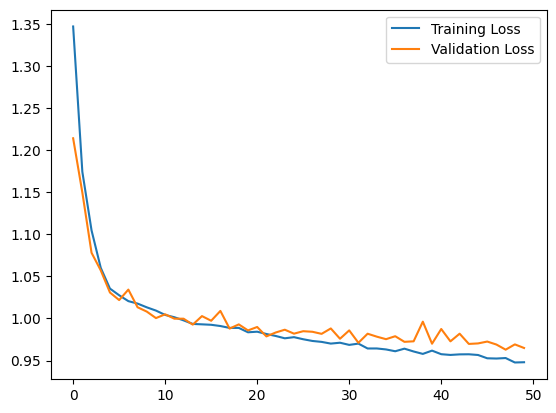

In [86]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

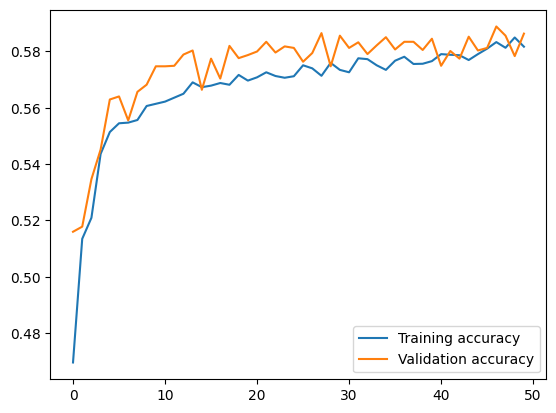

In [87]:
plt.plot(range(len(history.history["accuracy"])),history.history["accuracy"],label="Training accuracy")
plt.plot(range(len(history.history["val_accuracy"])),history.history["val_accuracy"],label="Validation accuracy")
plt.legend()